# Crop and resize images

The images are 3552x3552 pixels and contain a lot of empty space at the edges. Here we crop the images to 2048x2048 toward the center. Then they are resized to 64x64.

In [ ]:
from PIL import Image
import os
from pprint import pprint

dirs = [ (f'.\\data\\raw_data\\{num}', f'.\\data\\processed_64\\{num}') for num in range(16) ]
# dirs = [("./data/sanity_check_raw", "./data/sanity_check")]

pprint(dirs)
for (in_dir, out_dir) in dirs:
    os.makedirs(out_dir, exist_ok=True)

original_size = 3552
crop_size = 2048
target_size = 64
max_files = 60 # We want the same number of images of each ball

In [ ]:
left = (original_size - crop_size) // 2
top = (original_size - crop_size) // 2
right = (original_size + crop_size) // 2
bottom = (original_size + crop_size) // 2

for (in_dir, out_dir) in dirs:
    files = os.listdir(in_dir)
    print(f"Processing {in_dir} ...")

    counter = 0
    for filename in files[:max_files]:
        if filename.lower().endswith(".jpg"):
            counter += 1
            # Open the image
            img_path = os.path.join(in_dir, filename)
            output_path = os.path.join(out_dir, filename)
            
            Image.open(img_path
                ).crop((left, top, right, bottom)
                ).resize((target_size, target_size), Image.Resampling.LANCZOS
                ).save(output_path)

            # print(f"Cropped and saved: {output_path} ({counter} of {max_files})")

# Split the data into training, validation and testing datasets

We have 960 images (60 of each class). We will split these into

720 training images (75 %)\
80 validation images (8.33 %)\
160 testing images (16.67 %)

In [20]:
import numpy as np
import keras
from sklearn.model_selection import train_test_split
import tensorflow as tf

data_dir = './data/processed_64'
batch_size = 25
img_width = 64
img_height = 64

dataset = keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='int'
)

class_names = dataset.class_names # ['0', '1', '10', '11', '12', '13', '14', '15', '2', '3', '4', '5', '6', '7', '8', '9']

image_batches = []
label_batches = []

for images, labels in dataset:
    image_batches.append(images)
    label_batches.append(labels)

X = np.concatenate(image_batches)
y = np.concatenate(label_batches)

print("Splitting data into training, validation and testing datasets...")

X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size = 0.25, random_state = 0)

X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size = (2/3), random_state = 0)

print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_val", X_val.shape)
print("y_val", y_val.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

Found 960 files belonging to 16 classes.
Splitting data into training, validation and testing datasets...
X_train (720, 64, 64, 3)
y_train (720,)
X_val (80, 64, 64, 3)
y_val (80,)
X_test (160, 64, 64, 3)
y_test (160,)


# Data augmentation

We can use `keras` layers utility to apply random flips, rotations and brightness adjustment to prepare the training dataset.

In [21]:
from keras import layers
import tensorflow as tf
import numpy as np

normalization_layer = keras.layers.Rescaling(1./255) # Rescale RGB values from 0..255 to floats in 0..1

augmentation_layer = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.3),
    layers.RandomBrightness(0.1)
])

batch_size = 50
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.map(
    lambda x, y: (augmentation_layer(x), y)).map(
    lambda x, y: (normalization_layer(x), y)
    ).shuffle(buffer_size=len(X_train), seed=0, reshuffle_each_iteration=True
    ).batch(batch_size
    ).prefetch(buffer_size=AUTOTUNE)

val_ds = val_ds.map(
    lambda x, y: (normalization_layer(x), y)
    ).batch(batch_size
    ).prefetch(buffer_size=AUTOTUNE)

test_ds = test_ds.map(
    lambda x, y: (normalization_layer(x), y)
    ).batch(batch_size
    ).prefetch(buffer_size=AUTOTUNE)

# Visualize the training dataset images

Here we can see that the images have different brightness levels and rotations

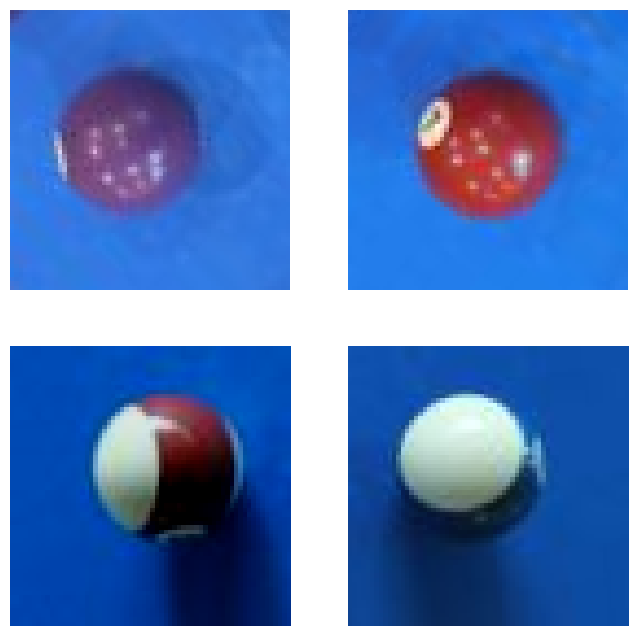

In [26]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Select an image from X_train, e.g., the first image
images, labels = next(iter(train_ds.take(1)))

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

# Display each image
axs[0, 0].imshow(images[0])
axs[0, 1].imshow(images[1])
axs[1, 0].imshow(images[2])
axs[1, 1].imshow(images[3])

# Turn off axes for all subplots
for ax in axs.flat:
    ax.axis('off')

plt.show()